If you're on Colab, upload your CSV now (e.g., Nat_Gas.csv)...


Saving Nat_Gas.csv to Nat_Gas.csv
Using uploaded file: Nat_Gas.csv


/tmp/ipython-input-2036909771.py:55: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["date"] = pd.to_datetime(df["date"], errors="coerce")
/tmp/ipython-input-2036909771.py:121: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y = df.set_index("date")["price"].asfreq("M")
/tmp/ipython-input-2036909771.py:121: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y = df.set_index("date")["price"].asfreq("M")
/tmp/ipython-input-2036909771.py:121: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y = df.set_index("date")["price"].asfreq("M")
/tmp/ipython-input-2036909771.py:121: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y = df.set_index("date")["

Backtest (avg):
 mape_ols    1.568
mape_ets    1.568
rmse_ols    0.216
rmse_ets    0.216
dtype: float64
Model winner: ets
Last historical date: 2024-09-30
Example: 2024-12-01 -> 12.6908


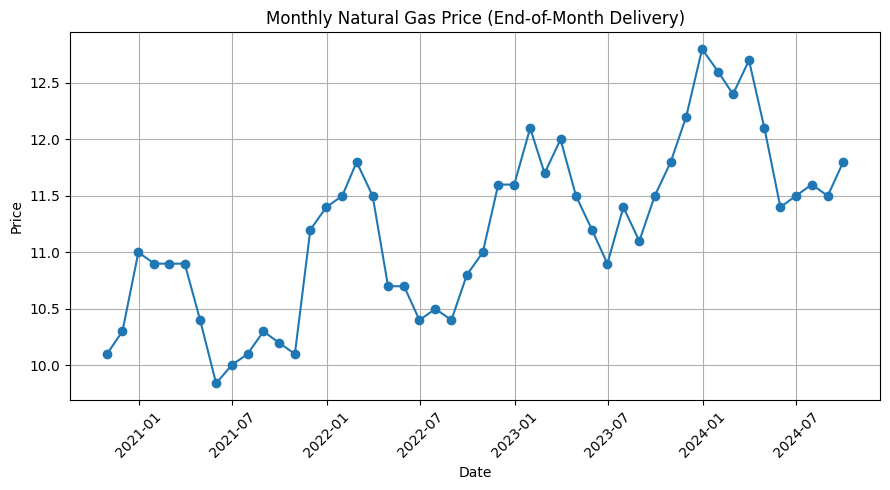

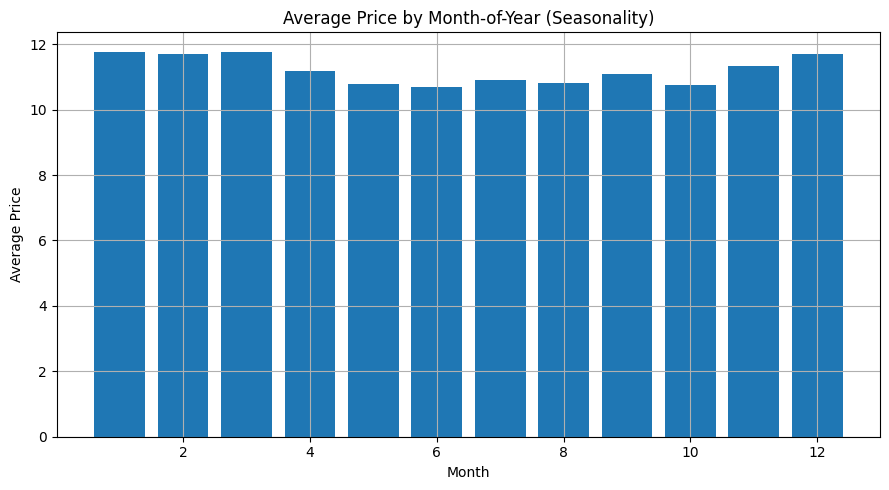

Backtest averages:
 mape_ols    1.568
mape_ets    1.568
rmse_ols    0.216
rmse_ets    0.216
dtype: float64


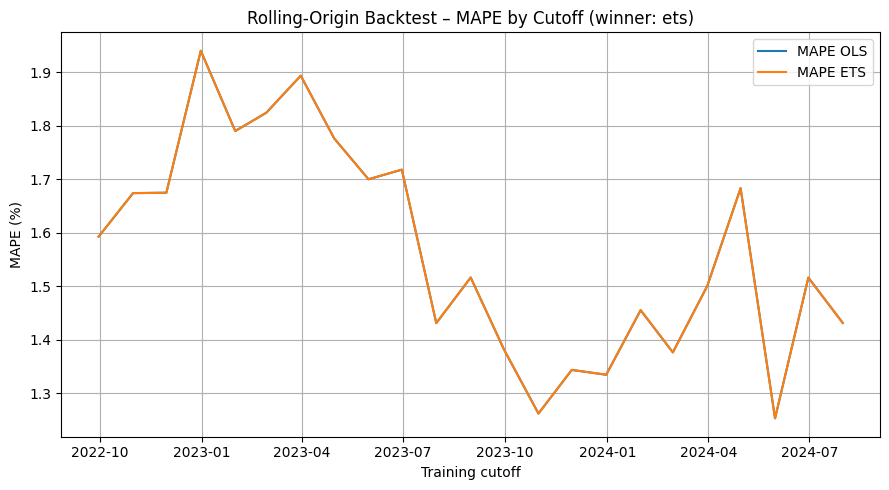

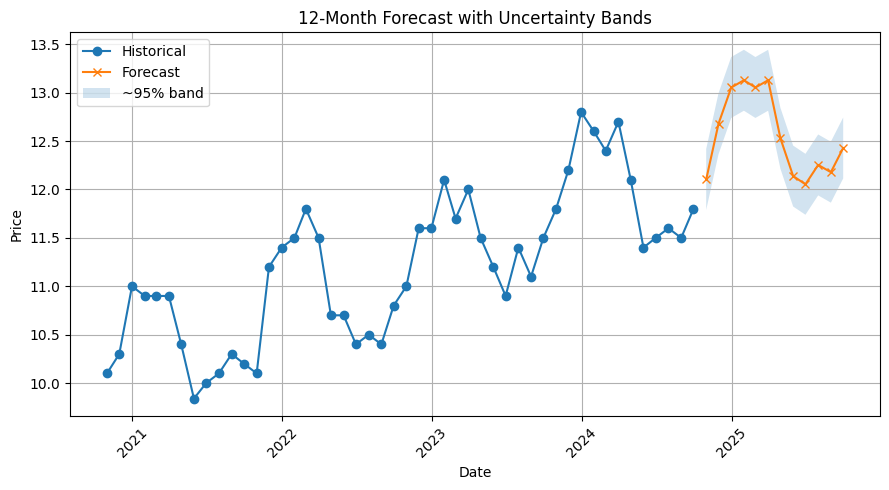

2021-02-15 -> 10.9
2023-07-15 -> 11.1419
2024-12-01 -> 12.6908
2025-06-30 -> 12.0538


In [ ]:
# Task 1 — Natural Gas Price Estimator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Optional, Dict
from statsmodels.tsa.holtwinters import ExponentialSmoothing

plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['axes.grid'] = True

# ---------- Utilities ----------

def _infer_cols(df: pd.DataFrame) -> Tuple[str, str]:
    """Infer date and price columns from flexible headers."""
    cols = [c.lower().strip() for c in df.columns]
    date_idx = None
    for i, c in enumerate(cols):
        if any(k in c for k in ["date", "month", "eom", "delivery"]):
            date_idx = i
            break
    if date_idx is None:
        raise ValueError("No date-like column found (expected something like 'Date', 'Month', 'EOM', 'Delivery').")

    price_idx = None
    for i, c in enumerate(cols):
        if any(k in c for k in ["price", "settle", "value", "px", "close"]):
            price_idx = i
            break
    if price_idx is None:
        raise ValueError("No price-like column found (expected something like 'Price', 'Settle', 'Value').")

    return df.columns[date_idx], df.columns[price_idx]


def _end_of_month(d: pd.Timestamp) -> pd.Timestamp:
    return (pd.Timestamp(d) + pd.offsets.MonthEnd(0)).normalize()

def _validate_and_prepare(df: pd.DataFrame,
                          start: str = "2020-10-31",
                          end: str = "2024-09-30") -> pd.DataFrame:
    """Standardize columns, enforce monthly cadence, filter to range, add helpers."""
    date_col, price_col = _infer_cols(df)
    df = df.rename(columns={date_col: "date", price_col: "price"})
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date"])
    df["date"] = df["date"].dt.tz_localize(None).apply(_end_of_month)
    df = df.sort_values("date").reset_index(drop=True)

    # Deduplicate by last value in a month
    df = df.groupby(df["date"]).tail(1).reset_index(drop=True)

    # Filter to expected range if present in file
    start_ts, end_ts = pd.Timestamp(start), pd.Timestamp(end)
    df = df[(df["date"] >= start_ts) & (df["date"] <= end_ts)].copy()

    if len(df) < 2:
        raise ValueError("Not enough data after cleaning. Check date range or input file.")

    # Validate monotonic monthly cadence; if gaps, reindex monthly & interpolate
    month_numbers = df["date"].dt.to_period("M").astype("int64")
    month_step = month_numbers.diff().dropna()
    if (month_step > 1).any():
        full_idx = pd.period_range(
            df["date"].iloc[0].to_period("M"),
            df["date"].iloc[-1].to_period("M"),
            freq="M"
        ).to_timestamp("M")
        df = df.set_index("date").reindex(full_idx)
        df.index.name = "date"
        df["price"] = df["price"].interpolate(method="time")
        df = df.reset_index()

    # Helpers
    df["month"] = df["date"].dt.month
    df["year"] = df["date"].dt.year
    df["t"] = np.arange(len(df))
    return df[["date", "price", "month", "year", "t"]]


# ---------- Models ----------

def fit_ols(df: pd.DataFrame) -> Dict:
    """OLS with trend + month-of-year seasonality (dummy variables)."""
    month_dummies = pd.get_dummies(df["month"].astype(int), prefix="m", drop_first=True)
    X = pd.concat([df[["t"]], month_dummies], axis=1).astype(float)
    y = df["price"].astype(float)

    X_mat = np.column_stack([np.ones(len(X)), X.values])
    beta, *_ = np.linalg.lstsq(X_mat, y.values, rcond=None)

    resid = y.values - X_mat @ beta
    resid_std = float(np.std(resid, ddof=X_mat.shape[1])) if len(y) > X_mat.shape[1] else float(np.std(resid))

    def predict(dates: pd.Series) -> np.ndarray:
        start_t = int(df["t"].iloc[-1]) + 1
        preds = []
        for i, d in enumerate(dates):
            t_idx = start_t + i
            row = [1.0, float(t_idx)]
            for m in range(2, 13):
                row.append(1.0 if d.month == m else 0.0)
            preds.append(float(np.dot(row, beta)))
        return np.array(preds, dtype=float)

    return {"name": "ols", "beta": beta, "resid_std": resid_std, "predict": predict}


def fit_ets(df: pd.DataFrame) -> Dict:
    """Holt-Winters ETS with additive trend & additive seasonality (12 months)."""
    y = df.set_index("date")["price"].asfreq("M")
    model = ExponentialSmoothing(
        y,
        trend="add",
        seasonal="add",
        seasonal_periods=12,
        initialization_method="estimated"
    ).fit(optimized=True)
    resid = y - model.fittedvalues
    resid_std = float(np.std(resid.dropna(), ddof=1))

    def predict(dates: pd.Series) -> np.ndarray:
        return model.forecast(len(dates)).values.astype(float)

    return {"name": "ets", "model": model, "resid_std": resid_std, "predict": predict}

# ---------- Backtesting & selection ----------

def _mape(y_true, y_pred) -> float:
    yt, yp = np.asarray(y_true), np.asarray(y_pred)
    mask = yt != 0
    return float(np.mean(np.abs((yt[mask] - yp[mask]) / yt[mask])) * 100)

def _rmse(y_true, y_pred) -> float:
    return float(np.sqrt(np.mean((np.asarray(y_true) - np.asarray(y_pred)) ** 2)))

def rolling_backtest(df: pd.DataFrame, horizon: int = 12, min_train: int = 24) -> pd.DataFrame:
    """Expanding-window backtest for OLS and ETS. Forecast up to 'horizon' at each step."""
    rows = []
    for cut in range(min_train, len(df) - 1):
        train = df.iloc[:cut].copy()
        test = df.iloc[cut:].copy()
        max_h = min(horizon, len(test))
        future_dates = test["date"].iloc[:max_h]

        ols = fit_ols(train)
        ets = fit_ets(train)

        ols_fc = ols["predict"](future_dates)
        ets_fc = ets["predict"](future_dates)

        y_true = test["price"].iloc[:max_h].values
        rows.append({
            "cutoff": train["date"].iloc[-1],
            "h": int(max_h),
            "rmse_ols": _rmse(y_true, ols_fc),
            "rmse_ets": _rmse(y_true, ets_fc),
            "mape_ols": _mape(y_true, ols_fc),
            "mape_ets": _mape(y_true, ets_fc),
        })
    return pd.DataFrame(rows)

def choose_model(df: pd.DataFrame, verbose: bool = True) -> Dict:
    """Backtest and return the better model (lower average MAPE; RMSE tie-breaker)."""
    bt = rolling_backtest(df, horizon=12, min_train=min(24, max(12, len(df) // 2)))
    if bt.empty:
        # Fallback: compare in-sample fit
        ols = fit_ols(df)
        ets = fit_ets(df)
        y = df["price"].values
        m = pd.get_dummies(df["month"].astype(int), prefix="m", drop_first=True)
        X = np.column_stack([np.ones(len(df)), pd.concat([df[["t"]], m], axis=1).values])
        rmse_ols = _rmse(y, X @ ols["beta"])
        rmse_ets = _rmse(y, ets["model"].fittedvalues.values)
        winner = "ets" if rmse_ets < rmse_ols else "ols"
        return {"winner": winner, "bt": bt, "model": ets if winner == "ets" else ols}

    avg = bt[["mape_ols", "mape_ets", "rmse_ols", "rmse_ets"]].mean()
    if verbose:
        print("Backtest (avg):\n", avg.round(3))

    if avg["mape_ets"] < avg["mape_ols"] - 1e-9:
        winner = "ets"
    elif avg["mape_ols"] < avg["mape_ets"] - 1e-9:
        winner = "ols"
    else:
        winner = "ets" if avg["rmse_ets"] <= avg["rmse_ols"] else "ols"

    model = fit_ets(df) if winner == "ets" else fit_ols(df)
    return {"winner": winner, "bt": bt, "model": model}

# ---------- Forecast & Estimator ----------

@dataclass
class Estimator:
    anchors: pd.DataFrame
    last_hist_date: pd.Timestamp

    def estimate(self, any_date) -> float:
        """Return price estimate for any date by linear interpolation between anchors."""
        if not isinstance(any_date, pd.Timestamp):
            any_date = pd.to_datetime(any_date)

        a = self.anchors
        if any_date <= a["date"].iloc[0]:
            return float(a["price"].iloc[0])
        if any_date >= a["date"].iloc[-1]:
            return float(a["price"].iloc[-1])

        idx_next = a[a["date"] >= any_date].index[0]
        idx_prev = idx_next - 1
        d0, p0 = a.loc[idx_prev, "date"], float(a.loc[idx_prev, "price"])
        d1, p1 = a.loc[idx_next, "date"], float(a.loc[idx_next, "price"])
        frac = (any_date - d0) / (d1 - d0)
        return float(p0 + frac * (p1 - p0))

def build_estimator(csv_path: str,
                    date_range=("2020-10-31", "2024-09-30"),
                    model_choice: str = "auto",
                    horizon_months: int = 12,
                    verbose: bool = False):
    """Load data, select/fit model, produce monthly anchors (hist + forecast), return (estimator, backtest, prepared_df, winner)."""
    raw = pd.read_csv(csv_path)
    df = _validate_and_prepare(raw, start=date_range[0], end=date_range[1])

    # Choose model
    if model_choice == "auto":
        picked = choose_model(df, verbose=verbose)
        model = picked["model"]
        backtest = picked["bt"]
        winner = picked["winner"]
    elif model_choice == "ols":
        model = fit_ols(df)
        backtest = None
        winner = "ols"
    elif model_choice == "ets":
        model = fit_ets(df)
        backtest = None
        winner = "ets"
    else:
        raise ValueError("model_choice must be 'auto', 'ols', or 'ets'")

    # Build forecast horizon dates
    last_date = df["date"].iloc[-1]
    future_dates = pd.Series([(last_date + pd.offsets.MonthEnd(i)) for i in range(1, horizon_months + 1)], name="date")

    # Forecast using selected model
    preds = model["predict"](future_dates)

    # Simple uncertainty bands using residual std dev
    resid_std = float(model.get("resid_std", np.std(df["price"].diff().dropna())))
    low = preds - 1.96 * resid_std
    high = preds + 1.96 * resid_std

    hist = df[["date", "price"]].copy()
    hist["is_forecast"] = False
    hist["low"] = np.nan
    hist["high"] = np.nan

    fut = pd.DataFrame({"date": future_dates, "price": preds, "low": low, "high": high})
    fut["is_forecast"] = True

    anchors = pd.concat([hist, fut], ignore_index=True).sort_values("date").reset_index(drop=True)
    return Estimator(anchors=anchors, last_hist_date=last_date), backtest, df, winner

# ---------- Plotting ----------

def plot_all(df_hist: pd.DataFrame, est: Estimator, bt: Optional[pd.DataFrame] = None, winner: Optional[str]=None):
    """EDA + seasonality + (optional) backtest + forecast fan chart."""
    # 1) Raw historical
    plt.figure()
    plt.plot(df_hist["date"], df_hist["price"], marker="o")
    plt.title("Monthly Natural Gas Price (End-of-Month Delivery)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 2) Seasonality
    sea = df_hist.groupby("month")["price"].mean().reindex(range(1, 13))
    plt.figure()
    plt.bar(sea.index, sea.values)
    plt.title("Average Price by Month-of-Year (Seasonality)")
    plt.xlabel("Month")
    plt.ylabel("Average Price")
    plt.tight_layout()
    plt.show()

    # 3) Backtest summary
    if bt is not None and not bt.empty:
        avg = bt[["mape_ols", "mape_ets", "rmse_ols", "rmse_ets"]].mean()
        print("Backtest averages:\n", avg.round(3))
        plt.figure()
        plt.plot(bt["cutoff"], bt["mape_ols"], label="MAPE OLS")
        plt.plot(bt["cutoff"], bt["mape_ets"], label="MAPE ETS")
        plt.title("Rolling-Origin Backtest – MAPE by Cutoff" + (f" (winner: {winner})" if winner else ""))
        plt.xlabel("Training cutoff")
        plt.ylabel("MAPE (%)")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # 4) Forecast fan chart
    a = est.anchors.copy()
    mask_hist = ~a["is_forecast"]
    plt.figure()
    plt.plot(a.loc[mask_hist, "date"], a.loc[mask_hist, "price"], marker="o", label="Historical")
    plt.plot(a.loc[~mask_hist, "date"], a.loc[~mask_hist, "price"], marker="x", label="Forecast")
    plt.fill_between(a.loc[~mask_hist, "date"], a.loc[~mask_hist, "low"], a.loc[~mask_hist, "high"], alpha=0.2, label="~95% band")
    plt.title("12-Month Forecast with Uncertainty Bands")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------- Convenience wrapper ----------

def estimate_any(estimator: Estimator, date_str: str) -> float:
    """Estimate price for an arbitrary date string YYYY-MM-DD."""
    return float(estimator.estimate(pd.to_datetime(date_str)))

# ---------- Example run ----------

if __name__ == "__main__":
    CSV_PATH = "/sample_data/Nat_Gas.csv"
    try:
        from google.colab import files  # type: ignore
        print("If you're on Colab, upload your CSV now (e.g., Nat_Gas.csv)...")
        uploaded = files.upload()
        if uploaded:
            CSV_PATH = list(uploaded.keys())[0]
            print(f"Using uploaded file: {CSV_PATH}")
    except Exception:
        print("Not on Colab (or upload skipped). Using default CSV_PATH:", CSV_PATH)

    estimator, backtest, df_prep, winner = build_estimator(
        CSV_PATH,
        date_range=("2020-10-31", "2024-09-30"),
        model_choice="auto",
        horizon_months=12,
        verbose=True
    )

    print("Model winner:", winner)
    print("Last historical date:", estimator.last_hist_date.date())
    print("Example:", "2024-12-01 ->", round(estimate_any(estimator, "2024-12-01"), 4))

    # Plots
    plot_all(df_prep, estimator, bt=backtest, winner=winner)

    # Test queries
    for d in ["2021-02-15", "2023-07-15", "2024-12-01", "2025-06-30"]:
        print(d, "->", round(estimate_any(estimator, d), 4))


In [ ]:
import pandas as pd
import numpy as np

# Wrap Task 1 estimator into a price function

def make_price_fn_from_estimator(estimator):
    def price_fn(d):
        return float(estimator.estimate(pd.to_datetime(d)))
    return price_fn

# Task 2: Prototype storage contract pricer

def price_storage_contract(
    injection_schedule,
    withdrawal_schedule,
    price_fn,
    inj_rate_per_day,
    wdr_rate_per_day,
    max_storage,
    storage_cost_per_unit_per_day,
    start_date=None,
    end_date=None,
    initial_inventory=0.0,
    sell_terminal_inventory=True,
):
    # Normalize input schedules
    inj_df = (pd.DataFrame(injection_schedule, columns=["date", "req_inj"])
              if injection_schedule else pd.DataFrame(columns=["date", "req_inj"]))
    wdr_df = (pd.DataFrame(withdrawal_schedule, columns=["date", "req_wdr"])
              if withdrawal_schedule else pd.DataFrame(columns=["date", "req_wdr"]))
    for df in (inj_df, wdr_df):
        if not df.empty:
            df["date"] = pd.to_datetime(df["date"]).dt.normalize()

    # Simulation calendar
    if start_date is None:
        candidates = []
        if not inj_df.empty: candidates.append(inj_df["date"].min())
        if not wdr_df.empty: candidates.append(wdr_df["date"].min())
        start_dt = min(candidates) if candidates else pd.Timestamp.today().normalize()
    else:
        start_dt = pd.to_datetime(start_date).normalize()

    if end_date is None:
        candidates = []
        if not inj_df.empty: candidates.append(inj_df["date"].max())
        if not wdr_df.empty: candidates.append(wdr_df["date"].max())
        end_dt = max(candidates) if candidates else start_dt
    else:
        end_dt = pd.to_datetime(end_date).normalize()

    days = pd.date_range(start_dt, end_dt, freq="D")
    inj_map = inj_df.groupby("date")["req_inj"].sum().to_dict()
    wdr_map = wdr_df.groupby("date")["req_wdr"].sum().to_dict()

    inv = float(initial_inventory)
    if inv > max_storage:
        raise ValueError("Initial inventory exceeds max_storage")

    records = []

    for d in days:
        price = float(price_fn(d))

        # Requested volumes
        req_inj = float(inj_map.get(d, 0.0))
        req_wdr = float(wdr_map.get(d, 0.0))

        # Apply daily rate limits
        inj_today = min(req_inj, inj_rate_per_day)
        wdr_today = min(req_wdr, wdr_rate_per_day)

        # Capacity constraints
        inj_today = min(inj_today, max(0.0, max_storage - inv))
        wdr_today = min(wdr_today, inv)

        # Cashflows
        cf_inj = -inj_today * price
        cf_wdr = +wdr_today * price
        inv_end = inv + inj_today - wdr_today

        cf_storage = -storage_cost_per_unit_per_day * inv_end
        cf_total = cf_inj + cf_wdr + cf_storage

        records.append({
            "date": d,
            "price": price,
            "req_inj": req_inj,
            "req_wdr": req_wdr,
            "inj": inj_today,
            "wdr": wdr_today,
            "inv_start": inv,
            "inv_end": inv_end,
            "cf_injection": cf_inj,
            "cf_withdrawal": cf_wdr,
            "cf_storage": cf_storage,
            "cf_total": cf_total,
        })

        inv = inv_end

    # Sell remaining inventory at last date if enabled
    if sell_terminal_inventory and inv > 0:
        last_price = float(price_fn(end_dt))
        cf_term = inv * last_price
        records.append({
            "date": end_dt,
            "price": last_price,
            "req_inj": 0.0,
            "req_wdr": 0.0,
            "inj": 0.0,
            "wdr": inv,
            "inv_start": inv,
            "inv_end": 0.0,
            "cf_injection": 0.0,
            "cf_withdrawal": cf_term,
            "cf_storage": 0.0,
            "cf_total": cf_term,
        })
        inv = 0.0

    ledger = pd.DataFrame(records)
    pv = float(ledger["cf_total"].sum())

    return {"pv": pv, "ledger": ledger}

# Example test run

price_fn = make_price_fn_from_estimator(estimator)

# Sample injection/withdrawal schedule
injections = [("2024-11-15", 50.0), ("2024-12-10", 40.0)]
withdrawals = [("2025-04-10", 40.0), ("2025-06-15", 40.0)]

result = price_storage_contract(
    injection_schedule=injections,
    withdrawal_schedule=withdrawals,
    price_fn=price_fn,
    inj_rate_per_day=60.0,
    wdr_rate_per_day=60.0,
    max_storage=120.0,
    storage_cost_per_unit_per_day=0.01,
    start_date="2024-11-01",
    end_date="2025-09-30",
    initial_inventory=0.0,
    sell_terminal_inventory=True,
)

print("Prototype contract value:", round(result["pv"], 4))

# Show the key event days
print(result["ledger"].query("inj > 0 or wdr > 0")[["date","price","inj","wdr","inv_end","cf_total"]])


Prototype contract value: -171.4637
          date      price   inj   wdr  inv_end    cf_total
14  2024-11-15  12.391251  50.0   0.0     50.0 -620.062570
39  2024-12-10  12.799720  40.0   0.0     90.0 -512.888781
160 2025-04-10  12.928751   0.0  40.0     50.0  516.650051
226 2025-06-15  12.096252   0.0  40.0     10.0  483.750087
334 2025-09-30  12.428753   0.0  10.0      0.0  124.287528


In [ ]:
!pip install reportlab --quiet

In [ ]:
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import letter
from reportlab.lib import colors
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle, Image, PageBreak
from reportlab.lib.styles import getSampleStyleSheet

def _save_fig_to_png(save_path: str):
    """Save current matplotlib figure to PNG file."""
    plt.tight_layout()
    plt.savefig(save_path, dpi=160, bbox_inches="tight")
    plt.close()

def make_plots_to_files(df_hist: pd.DataFrame, est, bt: pd.DataFrame | None, winner: str | None, out_dir: str):
    """Re-render the four plots to PNGs for embedding into the PDF."""
    os.makedirs(out_dir, exist_ok=True)
    paths = {}

    # 1) Raw historical
    plt.figure(figsize=(9, 5))
    plt.plot(df_hist["date"], df_hist["price"], marker="o")
    plt.title("Monthly Natural Gas Price (End-of-Month Delivery)")
    plt.xlabel("Date"); plt.ylabel("Price"); plt.xticks(rotation=45)
    p1 = os.path.join(out_dir, "history.png"); _save_fig_to_png(p1)
    paths["history"] = p1

    # 2) Seasonality
    sea = df_hist.groupby("month")["price"].mean().reindex(range(1, 13))
    plt.figure(figsize=(9, 5))
    plt.bar(sea.index, sea.values)
    plt.title("Average Price by Month-of-Year (Seasonality)")
    plt.xlabel("Month"); plt.ylabel("Average Price")
    p2 = os.path.join(out_dir, "seasonality.png"); _save_fig_to_png(p2)
    paths["seasonality"] = p2

    # 3) Backtest curve
    if bt is not None and not bt.empty:
        plt.figure(figsize=(9, 5))
        plt.plot(bt["cutoff"], bt["mape_ols"], label="MAPE OLS")
        plt.plot(bt["cutoff"], bt["mape_ets"], label="MAPE ETS")
        ttl = "Rolling-Origin Backtest – MAPE by Cutoff"
        if winner: ttl += f" (winner: {winner})"
        plt.title(ttl); plt.xlabel("Training cutoff"); plt.ylabel("MAPE (%)"); plt.legend()
        p3 = os.path.join(out_dir, "backtest.png"); _save_fig_to_png(p3)
        paths["backtest"] = p3

    # 4) Forecast fan chart
    a = est.anchors.copy()
    mask_hist = ~a["is_forecast"]
    plt.figure(figsize=(9, 5))
    plt.plot(a.loc[mask_hist, "date"], a.loc[mask_hist, "price"], marker="o", label="Historical")
    plt.plot(a.loc[~mask_hist, "date"], a.loc[~mask_hist, "price"], marker="x", label="Forecast")
    plt.fill_between(a.loc[~mask_hist, "date"], a.loc[~mask_hist, "low"], a.loc[~mask_hist, "high"],
                     alpha=0.2, label="~95% band")
    plt.title("12-Month Forecast with Uncertainty Bands")
    plt.xlabel("Date"); plt.ylabel("Price"); plt.xticks(rotation=45); plt.legend()
    p4 = os.path.join(out_dir, "forecast.png"); _save_fig_to_png(p4)
    paths["forecast"] = p4

    return paths

def build_summary_tables(backtest: pd.DataFrame | None, estimator, anchors_rows: int = 12):
    """Create data for PDF tables: metrics & forecast head."""
    # Metrics table
    if backtest is not None and not backtest.empty:
        avg = backtest[["rmse_ols", "rmse_ets", "mape_ols", "mape_ets"]].mean().round(3)
        metrics = [
            ["Metric", "OLS", "ETS"],
            ["Average RMSE", f"{avg['rmse_ols']}", f"{avg['rmse_ets']}"],
            ["Average MAPE (%)", f"{avg['mape_ols']}", f"{avg['mape_ets']}"],
        ]
    else:
        metrics = [
            ["Metric", "OLS", "ETS"],
            ["Average RMSE", "—", "—"],
            ["Average MAPE (%)", "—", "—"],
        ]

    # Forecast table (first N forecast rows)
    a = estimator.anchors.copy()
    fut = a[a["is_forecast"]].head(anchors_rows).copy()
    fut_display = [["Date", "Forecast", "Low (~95%)", "High (~95%)"]]
    for _, r in fut.iterrows():
        fut_display.append([
            r["date"].date().isoformat(),
            f"{r['price']:.4f}",
            f"{r['low']:.4f}",
            f"{r['high']:.4f}",
        ])
    return metrics, fut_display

def export_pdf_report(output_pdf_path: str,
                      estimator,
                      backtest: pd.DataFrame | None,
                      df_prep: pd.DataFrame,
                      winner: str | None,
                      example_dates: list[str] = None,
                      img_paths: dict | None = None):
    """Create a polished PDF report with text, metrics, embedded plots, and a forecast table."""
    if example_dates is None:
        example_dates = ["2024-12-01", "2025-06-30"]

    styles = getSampleStyleSheet()
    story = []

    # Title & intro
    story.append(Paragraph("Natural Gas Price Forecast Report", styles["Title"]))
    story.append(Spacer(1, 8))
    story.append(Paragraph(
        "This report analyzes end-of-month natural gas prices from October 2020 through "
        "September 2024 and produces a 12-month forecast. We evaluate two models—"
        "OLS with month-of-year seasonality and Holt-Winters ETS—via a rolling-origin "
        "backtest (MAPE/RMSE) and select the stronger performer.", styles["BodyText"]))
    story.append(Spacer(1, 12))

    first_dt = df_prep["date"].iloc[0].date().isoformat()
    last_dt = df_prep["date"].iloc[-1].date().isoformat()
    story.append(Paragraph(f"<b>Historical coverage:</b> {first_dt} → {last_dt}", styles["BodyText"]))
    if winner:
        story.append(Paragraph(f"<b>Selected model:</b> {winner.upper()}", styles["BodyText"]))
    story.append(Spacer(1, 10))

    examples = []
    for d in example_dates:
        try:
            val = estimator.estimate(pd.to_datetime(d))
            examples.append([d, f"{val:.4f}"])
        except Exception as e:
            examples.append([d, f"Error: {e}"])
    examples = [["Date", "Estimated Price"]] + examples
    tbl = Table(examples, hAlign="LEFT")
    tbl.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('GRID', (0, 0), (-1, -1), 0.25, colors.black),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER')
    ]))
    story.append(tbl)
    story.append(Spacer(1, 12))

    metrics, forecast_table = build_summary_tables(backtest, estimator)
    story.append(Paragraph("<b>Backtest Averages</b>", styles["Heading3"]))
    mt = Table(metrics, hAlign="LEFT")
    mt.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('GRID', (0, 0), (-1, -1), 0.25, colors.black),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('BACKGROUND', (0, 1), (-1, -1), colors.whitesmoke),
    ]))
    story.append(mt)
    story.append(Spacer(1, 12))

    if img_paths:
        story.append(Paragraph("<b>Visualizations</b>", styles["Heading3"]))
        for key in ["history", "seasonality", "backtest", "forecast"]:
            if key in img_paths and os.path.exists(img_paths[key]):
                story.append(Paragraph(key.capitalize(), styles["BodyText"]))
                story.append(Image(img_paths[key], width=520, height=300))
                story.append(Spacer(1, 8))
        story.append(PageBreak())

    story.append(Paragraph("<b>First 12 Forecast Points (~95% bands)</b>", styles["Heading3"]))
    ft = Table(forecast_table, hAlign="LEFT", colWidths=[110, 100, 120, 120])
    ft.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (-1, 0), colors.grey),
        ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
        ('GRID', (0, 0), (-1, -1), 0.25, colors.black),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
    ]))
    story.append(ft)
    story.append(Spacer(1, 10))

    story.append(Paragraph(
        "Confidence bands are constructed heuristically using residual standard deviation "
        "from the selected model. Bands are indicative, not guarantees.", styles["BodyText"]))

    # Build PDF
    doc = SimpleDocTemplate(output_pdf_path, pagesize=letter)
    doc.build(story)
    return output_pdf_path

img_dir = "report_imgs"
img_paths = make_plots_to_files(df_prep, estimator, backtest, winner, img_dir)

# 2) Export the PDF:
pdf_path = "NatGas_Forecast_Report.pdf"
export_pdf_report(pdf_path, estimator, backtest, df_prep, winner,
                  example_dates=["2024-12-01", "2025-06-30"],
                  img_paths=img_paths)

print("PDF written to:", pdf_path)
